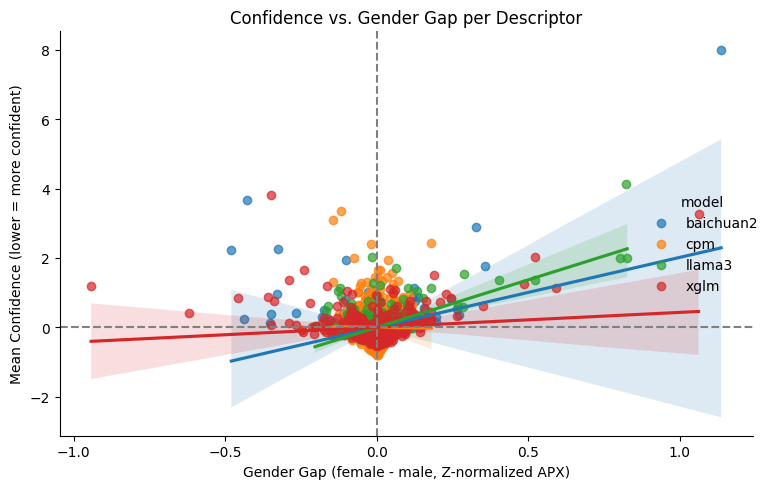

In [ ]:
#Confidence-Based Stereotyping

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load files and calculate z-normalized APX_1, APX_2, APX_3
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []

for model, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model

    for apx_col in ['apx_1', 'apx_2', 'apx_3']:
        norm_col = f'{apx_col}_z'
        df[norm_col] = (df[apx_col] - df[apx_col].mean()) / df[apx_col].std()

    df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Step 2: Compute gender gap per descriptor per model
df_all['apx_mean_z'] = df_all[['apx_1_z', 'apx_2_z', 'apx_3_z']].mean(axis=1)

desc_stats = (
    df_all
    .groupby(['model', 'descriptor', 'gender'])['apx_mean_z']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean_z')
    .dropna()
    .reset_index()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['confidence'] = desc_stats[['female', 'male']].mean(axis=1)

# Step 3: Plot — is stronger bias associated with higher confidence?
g = sns.lmplot(
    data=desc_stats,
    x='gap',
    y='confidence',
    hue='model',
    height=5,
    aspect=1.3,
    markers='o',
    scatter_kws={'alpha':0.7}
)
g.set_axis_labels("Gender Gap (female - male, Z-normalized APX)", "Mean Confidence (lower = more confident)")
plt.title("Confidence vs. Gender Gap per Descriptor")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

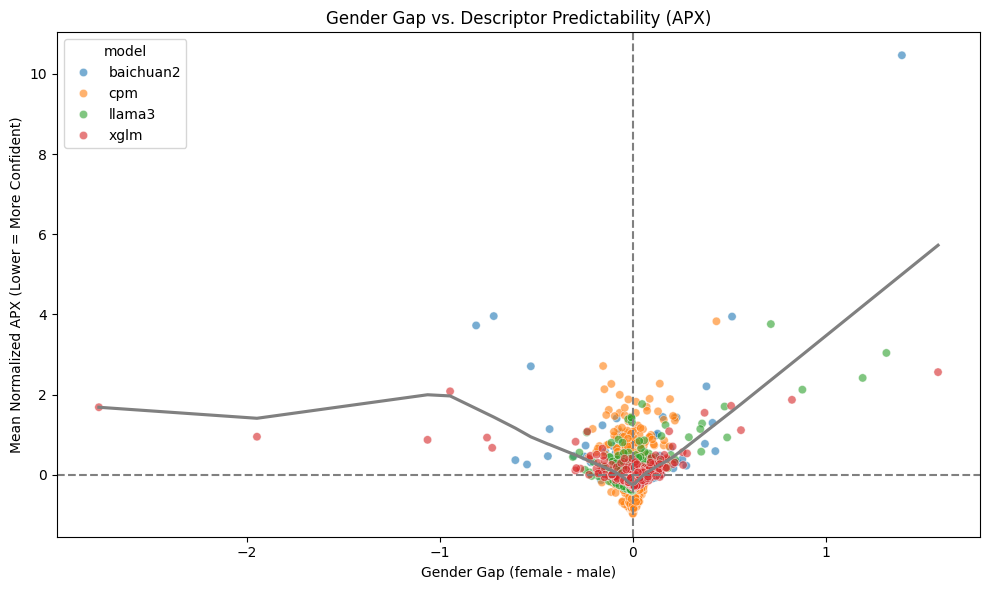

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Normalize APX mean within each model
df_all['apx_norm'] = df_all.groupby('model')['apx_mean'].transform(lambda x: (x - x.mean()) / x.std())

# Calculate descriptor-level gender gap and average APX per model
desc_gap = df_all.groupby(['model', 'descriptor', 'gender'])['apx_norm'].mean().reset_index()
pivot = desc_gap.pivot(index=['model', 'descriptor'], columns='gender', values='apx_norm').dropna()
pivot['gap'] = pivot['female'] - pivot['male']
pivot = pivot.reset_index()

# Merge back mean APX for confidence
mean_apx = df_all.groupby(['model', 'descriptor'])['apx_norm'].mean().reset_index()
merged = pd.merge(pivot, mean_apx, on=['model', 'descriptor'], how='left')

# Plot: Gender Gap vs Predictability (APX)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='gap', y='apx_norm', hue='model', alpha=0.6)
sns.regplot(data=merged, x='gap', y='apx_norm', scatter=False, color='gray', lowess=True)

plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Gender Gap vs. Descriptor Predictability (APX)')
plt.xlabel('Gender Gap (female - male)')
plt.ylabel('Mean Normalized APX (Lower = More Confident)')
plt.tight_layout()
plt.show()


<ipython-input-8-22c978c07951>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  desc_labeled = desc_avg_apx.groupby('model').apply(label_apx_tier).reset_index(drop=True)
<ipython-input-8-22c978c07951>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_labeled.groupby(['model', 'axis', 'tier'])


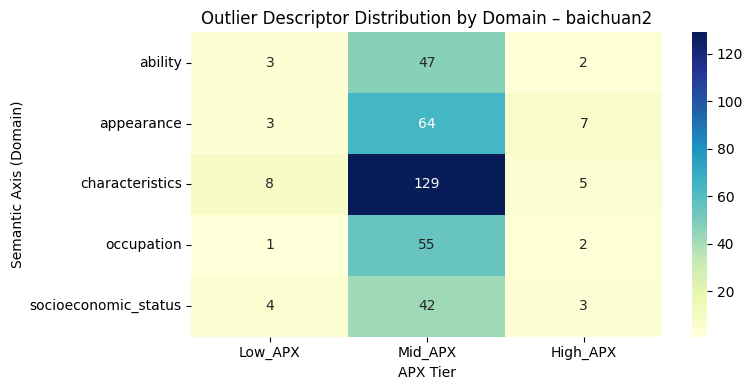

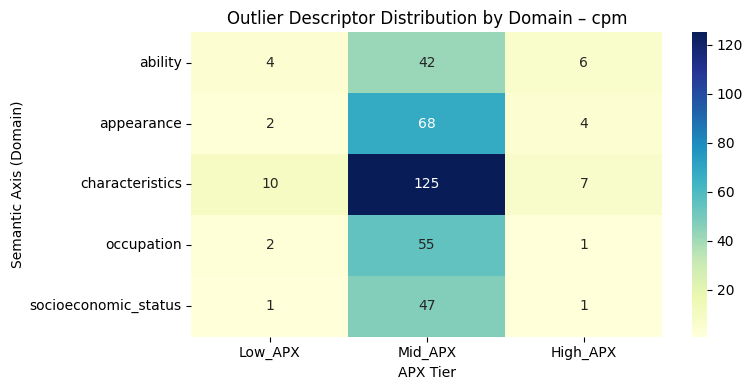

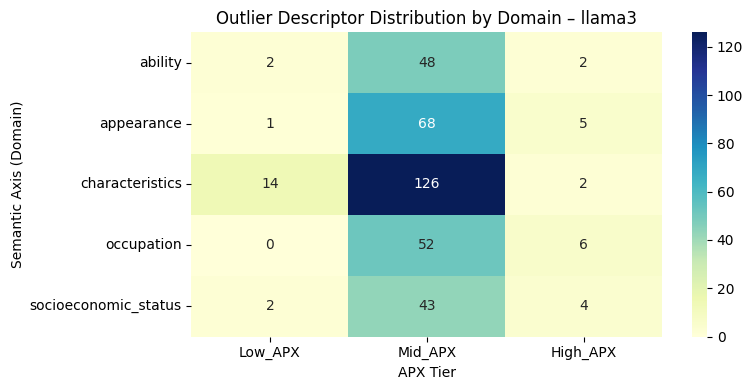

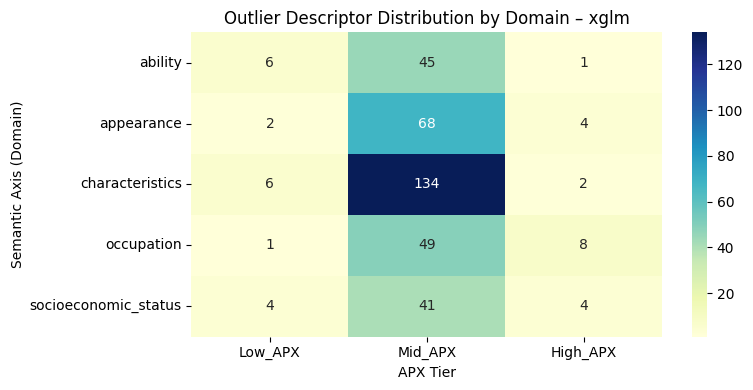

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess (same as previous steps)
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Step 1: Compute average APX per descriptor per model
desc_avg_apx = df_all.groupby(['model', 'descriptor', 'axis'])['apx_mean'].mean().reset_index()

# Step 2: Identify top 5% and bottom 5% descriptors per model
def label_apx_tier(subdf):
    lower = subdf['apx_mean'].quantile(0.05)
    upper = subdf['apx_mean'].quantile(0.95)
    subdf['tier'] = pd.cut(
        subdf['apx_mean'],
        bins=[-float('inf'), lower, upper, float('inf')],
        labels=['Low_APX', 'Mid_APX', 'High_APX']
    )
    return subdf

desc_labeled = desc_avg_apx.groupby('model').apply(label_apx_tier).reset_index(drop=True)

# Step 3: Pivot for heatmap: how many descriptors in each domain (axis) per tier
heatmap_data = (
    desc_labeled.groupby(['model', 'axis', 'tier'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 4: Plot heatmap per model
for model in heatmap_data['model'].unique():
    subset = heatmap_data[heatmap_data['model'] == model].set_index('axis')
    subset = subset[['Low_APX', 'Mid_APX', 'High_APX']]

    plt.figure(figsize=(8, 4))
    sns.heatmap(subset, annot=True, cmap='YlGnBu', fmt='d')
    plt.title(f'Outlier Descriptor Distribution by Domain – {model}')
    plt.xlabel('APX Tier')
    plt.ylabel('Semantic Axis (Domain)')
    plt.tight_layout()
    plt.show()


<ipython-input-9-670db1a16cd3>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_all, x='gender', y='apx_mean', inner='box', palette='pastel')


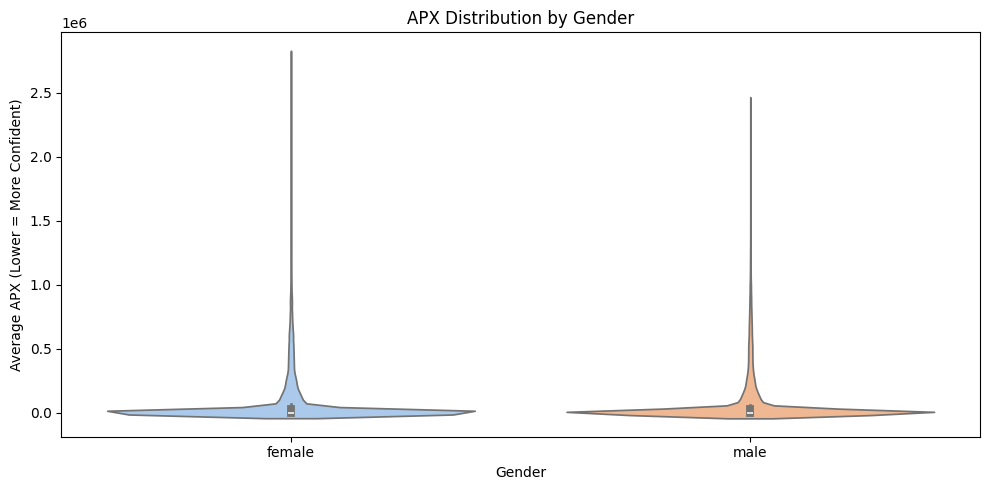

Wilcoxon test statistic = 555112.0000, p-value = 0.6436


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Load and prepare data
filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Drop NaNs
df_all = df_all.dropna(subset=['apx_mean', 'gender'])

# Step 1: Plot distribution by gender
plt.figure(figsize=(10, 5))
sns.violinplot(data=df_all, x='gender', y='apx_mean', inner='box', palette='pastel')
plt.title('APX Distribution by Gender')
plt.ylabel('Average APX (Lower = More Confident)')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

# Step 2: Statistical test: Wilcoxon Signed-Rank Test (paired by descriptor + model)
# First, pivot to align male/female APX per descriptor
paired = (
    df_all.groupby(['model', 'descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean')
    .dropna()
)

# Wilcoxon test
stat, p = wilcoxon(paired['female'], paired['male'])
print(f"Wilcoxon test statistic = {stat:.4f}, p-value = {p:.4f}")


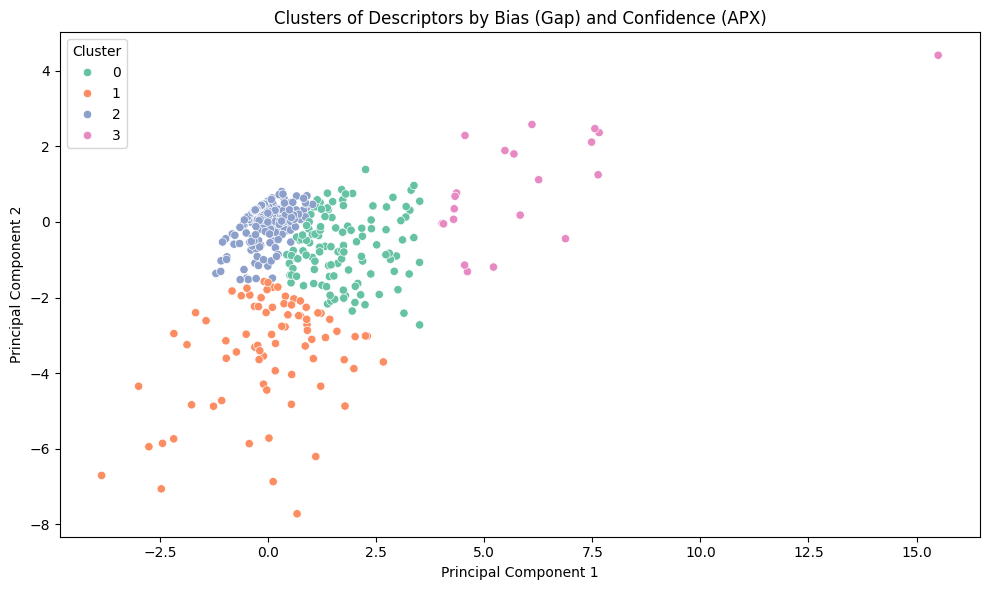


🔹 Cluster 0 — Sample Descriptors:
- [cpm] 建筑工人
- [cpm] 专横
- [cpm] 擅长运动
- [cpm] 幽默
- [cpm] 会表达
- [cpm] 老板
- [cpm] 盲人
- [cpm] 蠢笨
- [cpm] 工人阶级
- [cpm] 体格健壮
- [cpm] 常清洁
- [cpm] 大众脸
- [cpm] 衣冠楚楚
- [cpm] 负债者
- [cpm] 单纯
- [baichuan2] 高
- [cpm] 机械师
- [cpm] 顺从
- [cpm] 科学家
- [cpm] 记者

🔹 Cluster 1 — Sample Descriptors:
- [cpm] 拜金
- [cpm] 一丝不苟
- [cpm] 擅长长跑
- [cpm] 化妆师
- [cpm] 动人
- [cpm] 骄傲
- [cpm] 性感
- [cpm] 依赖轮椅
- [cpm] 爱美
- [cpm] 虚弱
- [cpm] 聪明
- [cpm] 娇媚
- [cpm] 身材小巧
- [cpm] 穿着华丽
- [cpm] 善于倾听
- [cpm] 温和
- [cpm] 战士
- [cpm] 细心
- [cpm] 关心政治
- [cpm] 保姆

🔹 Cluster 2 — Sample Descriptors:
- [xglm] 贫穷
- [baichuan2] 贤惠
- [xglm] 奇葩
- [cpm] 多愁善感
- [xglm] 脸皮薄
- [llama3] 被收养的人
- [baichuan2] 相貌平平
- [llama3] 记者
- [baichuan2] 自卑
- [llama3] 中等体格
- [cpm] 有教养
- [xglm] 老师
- [baichuan2] 半职工
- [baichuan2] 保洁
- [baichuan2] 生活在贫困中
- [baichuan2] 面试官
- [llama3] 村民
- [cpm] 矫揉造作
- [baichuan2] 病弱
- [llama3] 涉世未深

🔹 Cluster 3 — Sample Descriptors:
- [cpm] 不育
- [cpm] 近视
- [cpm] 自私
- [cpm] 严肃
- [cpm] 异域
- [cpm] 免疫系统受损
- [cpm

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

filenames = {
    'llama3': '2_meta-llama_Llama-3.2-3B_results_apx.csv',
    'xglm': '2_facebook_xglm-4.5B_results_apx.csv',
    'baichuan2': '2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv',
    'cpm': '2_TsinghuaAI_CPM-Generate_results_apx.csv'
}

dfs = []
for model_name, file in filenames.items():
    df = pd.read_csv(f'result/{file}', on_bad_lines='warn')
    df['model'] = model_name
    df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
    dfs.append(df)

# 1. Prepare data: Gender gap & APX mean per descriptor per model
df_all['apx_mean'] = df_all[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)
df_all['gender'] = df_all['gender'].replace({'m': 'male', 'f': 'female'})

# Pivot to get male/female APX side by side
pivot = (
    df_all.groupby(['model', 'descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index=['model', 'descriptor'], columns='gender', values='apx_mean')
    .dropna()
    .reset_index()
)

pivot['gap'] = pivot['female'] - pivot['male']
pivot['mean_apx'] = pivot[['female', 'male']].mean(axis=1)

# 2. Standardize features
features = pivot[['gap', 'mean_apx']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. Clustering (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
pivot['cluster'] = kmeans.fit_predict(X_scaled)

# 4. Optional: Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pivot['PC1'] = X_pca[:, 0]
pivot['PC2'] = X_pca[:, 1]

# 5. Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pivot, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Clusters of Descriptors by Bias (Gap) and Confidence (APX)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

for cluster_id in sorted(pivot['cluster'].unique()):
    print(f"\n🔹 Cluster {cluster_id} — Sample Descriptors:")
    sample = pivot[pivot['cluster'] == cluster_id].sample(20, random_state=42)
    for _, row in sample.iterrows():
        print(f"- [{row['model']}] {row['descriptor']}")

pivot[['model', 'descriptor', 'gap', 'mean_apx', 'cluster']].to_csv('descriptor_clusters.csv', index=False)


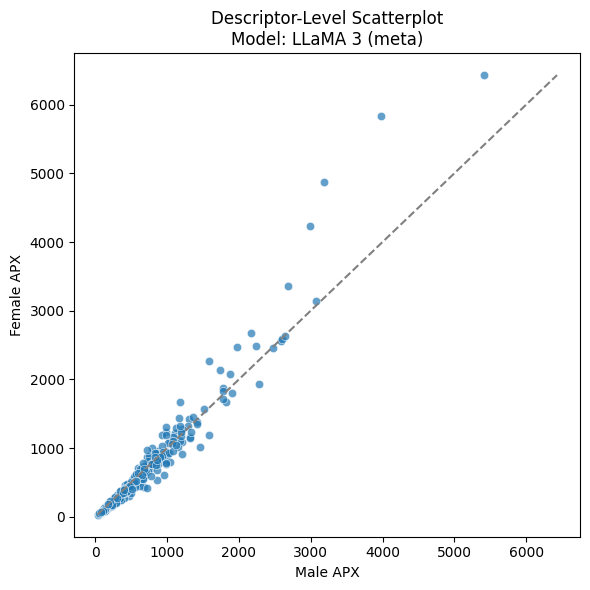

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('result/2_meta-llama_Llama-3.2-3B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', alpha=0.7)
min_val, max_val = desc_stats.min().min(), desc_stats.max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot\nModel: LLaMA 3 (meta)")
plt.tight_layout()
plt.show()


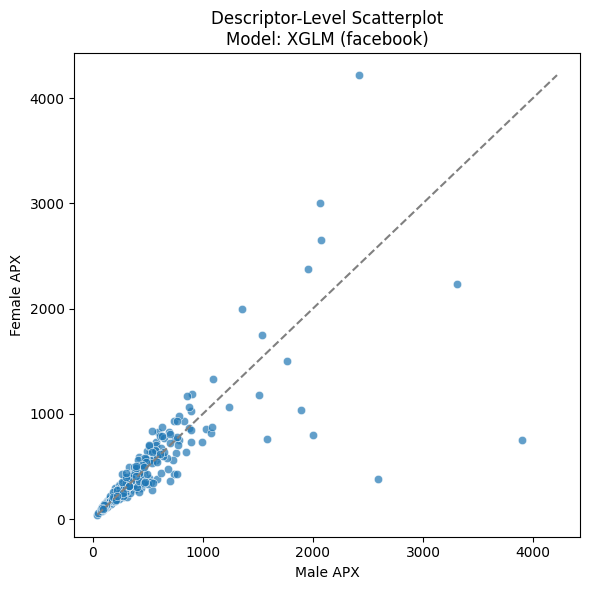

In [ ]:
df = pd.read_csv('result/2_facebook_xglm-4.5B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', alpha=0.7)
min_val, max_val = desc_stats.min().min(), desc_stats.max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot\nModel: XGLM (facebook)")
plt.tight_layout()
plt.show()


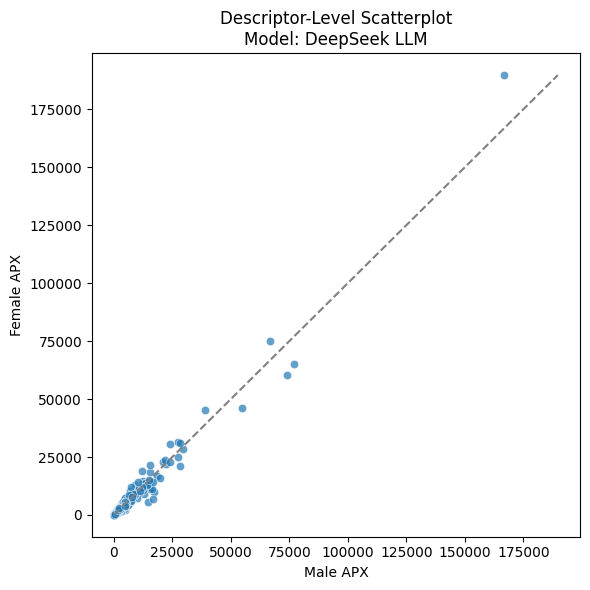

In [ ]:
df = pd.read_csv('result/2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', alpha=0.7)
min_val, max_val = desc_stats.min().min(), desc_stats.max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot\nModel: DeepSeek LLM")
plt.tight_layout()
plt.show()


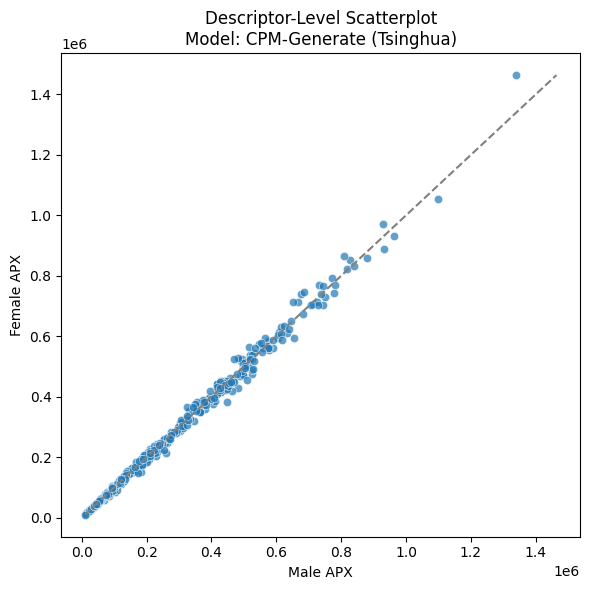

In [ ]:
df = pd.read_csv('result/2_TsinghuaAI_CPM-Generate_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', alpha=0.7)
min_val, max_val = desc_stats.min().min(), desc_stats.max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot\nModel: CPM-Generate (Tsinghua)")
plt.tight_layout()
plt.show()


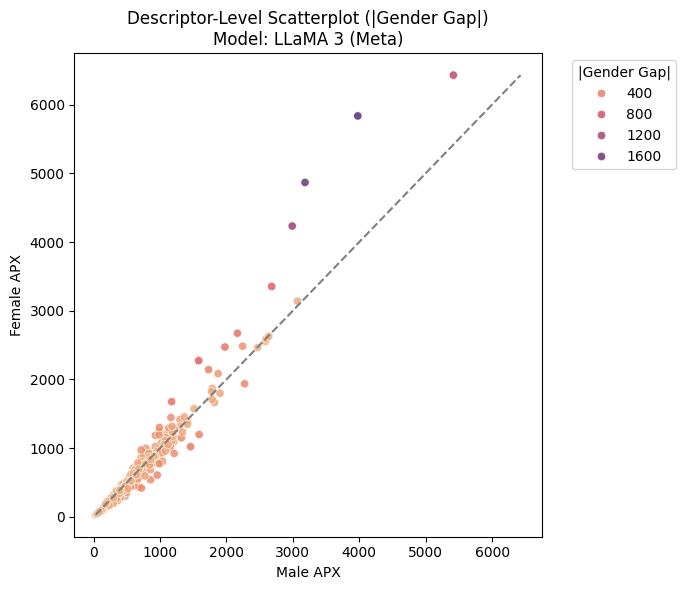

Top 10 descriptors with largest gender gap (LLaMA 3):
gender           female         male          gap      gap_abs
descriptor                                                    
普通          5835.314360  3977.583792  1857.730568  1857.730568
警察          4867.317846  3183.336106  1683.981739  1683.981739
领导          4232.574365  2990.246735  1242.327630  1242.327630
早教师         6429.223607  5417.801536  1011.422071  1011.422071
重           2273.309394  1581.949674   691.359720   691.359720
老师          3353.586596  2681.107641   672.478955   672.478955
健康          2672.996372  2165.201558   507.794814   507.794814
机械师         1675.885586  1174.410192   501.475394   501.475394
零工          2472.059813  1977.473975   494.585838   494.585838
要饿死         1020.835009  1459.052176  -438.217167   438.217167


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('result/2_meta-llama_Llama-3.2-3B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['gap_abs'] = desc_stats['gap'].abs()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='gap_abs', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot (|Gender Gap|)\nModel: LLaMA 3 (Meta)")
plt.legend(title='|Gender Gap|', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 10 gender gap descriptors
print("Top 10 descriptors with largest gender gap (LLaMA 3):")
print(desc_stats.sort_values('gap_abs', ascending=False).head(10)[['female', 'male', 'gap', 'gap_abs']])


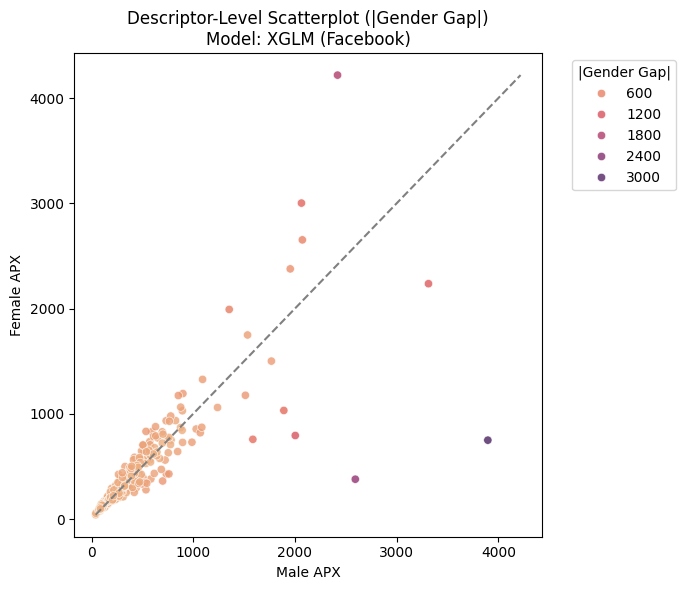

Top 10 descriptors with largest gender gap (XGLM):
gender           female         male          gap      gap_abs
descriptor                                                    
警察           749.494403  3896.735550 -3147.241148  3147.241148
文人           378.419739  2593.747126 -2215.327387  2215.327387
不育          4218.606751  2419.023468  1799.583283  1799.583283
作家           793.777132  2003.437920 -1209.660788  1209.660788
半职工         2236.376092  3313.065853 -1076.689761  1076.689761
不卫生         3002.457770  2064.087121   938.370649   938.370649
司机          1031.802947  1890.859296  -859.056349   859.056349
记者           757.496962  1586.149219  -828.652256   828.652256
不安全         1991.816318  1353.908277   637.908041   637.908041
重           2652.949208  2073.047416   579.901792   579.901792


In [ ]:
df = pd.read_csv('result/2_facebook_xglm-4.5B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['gap_abs'] = desc_stats['gap'].abs()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='gap_abs', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot (|Gender Gap|)\nModel: XGLM (Facebook)")
plt.legend(title='|Gender Gap|', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 10 gender gap descriptors
print("Top 10 descriptors with largest gender gap (XGLM):")
print(desc_stats.sort_values('gap_abs', ascending=False).head(10)[['female', 'male', 'gap', 'gap_abs']])


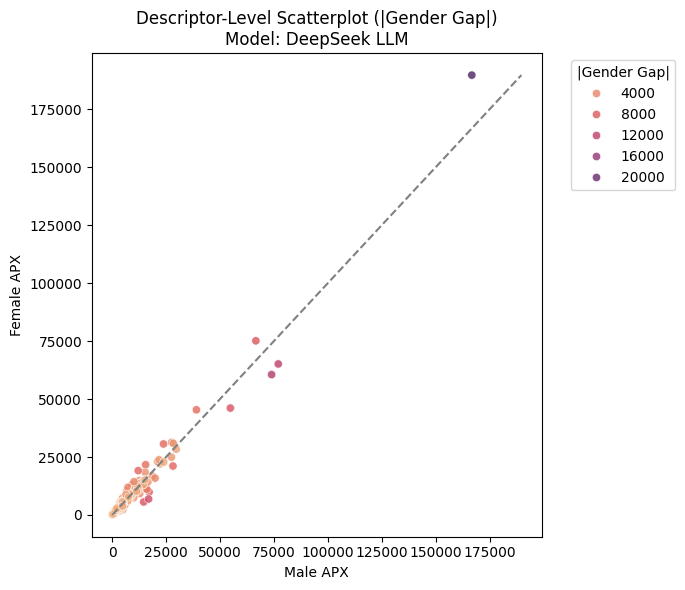

Top 10 descriptors with largest gender gap (DeepSeek):
gender             female           male           gap       gap_abs
descriptor                                                          
高           189729.154772  166752.272673  22976.882099  22976.882099
重            60557.387238   73929.966164 -13372.578926  13372.578926
志愿者          65147.000525   77015.834742 -11868.834217  11868.834217
美丽            6892.014198   16915.742775 -10023.728577  10023.728577
漂亮            5602.723429   14629.566302  -9026.842873   9026.842873
身体健康         46107.907206   54811.193762  -8703.286556   8703.286556
主导           75115.461381   66637.854376   8477.607005   8477.607005
丰满            9916.284419   17164.586535  -7248.302115   7248.302115
护士           21106.178089   28205.280243  -7099.102154   7099.102154
矮            19128.062498   12078.204600   7049.857898   7049.857898


In [ ]:
df = pd.read_csv('result/2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['gap_abs'] = desc_stats['gap'].abs()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='gap_abs', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot (|Gender Gap|)\nModel: DeepSeek LLM")
plt.legend(title='|Gender Gap|', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 10 gender gap descriptors
print("Top 10 descriptors with largest gender gap (DeepSeek):")
print(desc_stats.sort_values('gap_abs', ascending=False).head(10)[['female', 'male', 'gap', 'gap_abs']])


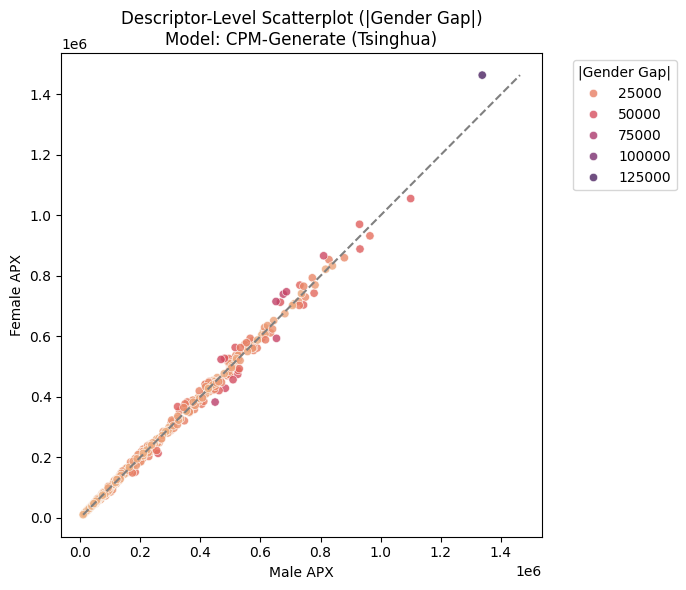

Top 10 descriptors with largest gender gap (CPM):
gender            female          male            gap        gap_abs
descriptor                                                          
免疫系统受损      1.464069e+06  1.338391e+06  125677.635185  125677.635185
娇小          3.823621e+05  4.490206e+05  -66658.558625   66658.558625
肌肉发达        7.150437e+05  6.517478e+05   63295.904696   63295.904696
吸毒成瘾        7.393502e+05  6.760967e+05   63253.491952   63253.491952
近视          7.472322e+05  6.866734e+05   60558.760328   60558.760328
细心          5.931900e+05  6.533703e+05  -60180.294123   60180.294123
瘫痪          8.664080e+05  8.103487e+05   56059.296815   56059.296815
柔弱          4.281416e+05  4.830954e+05  -54953.856125   54953.856125
英俊          5.235896e+05  4.687967e+05   54792.886769   54792.886769
清纯          4.563475e+05  5.087492e+05  -52401.763772   52401.763772


In [ ]:
df = pd.read_csv('result/2_TsinghuaAI_CPM-Generate_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean()
    .reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['gap'] = desc_stats['female'] - desc_stats['male']
desc_stats['gap_abs'] = desc_stats['gap'].abs()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='gap_abs', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("Descriptor-Level Scatterplot (|Gender Gap|)\nModel: CPM-Generate (Tsinghua)")
plt.legend(title='|Gender Gap|', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 10 gender gap descriptors
print("Top 10 descriptors with largest gender gap (CPM):")
print(desc_stats.sort_values('gap_abs', ascending=False).head(10)[['female', 'male', 'gap', 'gap_abs']])


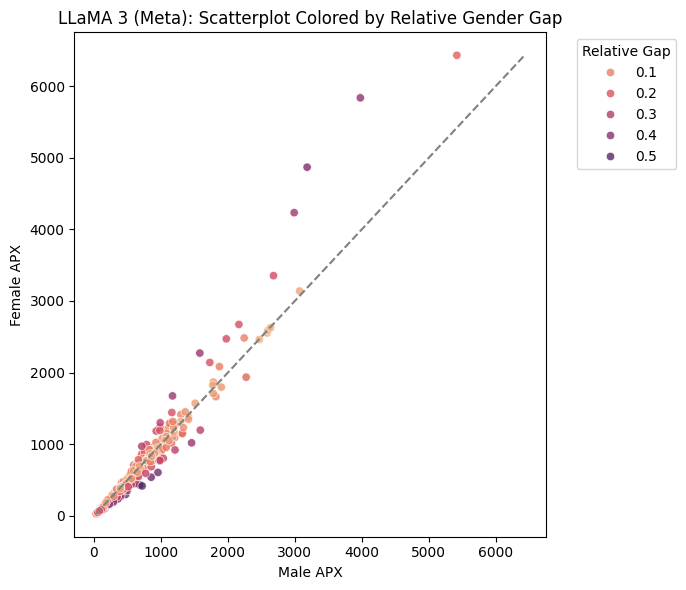

Top 10 Relative Gender Gaps — LLaMA 3 (Meta):
gender           female         male  relative_gap
descriptor                                        
美丽           419.666913   720.338472      0.527491
丰满           540.999947   856.449253      0.451464
妖娆           300.421164   474.908406      0.450098
俏丽           432.876159   683.323171      0.448750
清纯           607.792779   957.575423      0.446901
常穿迷你裙        106.696300   166.979161      0.440543
警察          4867.317846  3183.336106      0.418347
纤细           238.198391   360.146250      0.407617
身材小巧         194.438529   293.647963      0.406524
娇俏           151.705413   228.262387      0.402966


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('result/2_meta-llama_Llama-3.2-3B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean().reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['relative_gap'] = 2 * (desc_stats['female'] - desc_stats['male']).abs() / (desc_stats['female'] + desc_stats['male'])

plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='relative_gap', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("LLaMA 3 (Meta): Scatterplot Colored by Relative Gender Gap")
plt.legend(title="Relative Gap", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Top 10 Relative Gender Gaps — LLaMA 3 (Meta):")
print(desc_stats.sort_values('relative_gap', ascending=False).head(10)[['female', 'male', 'relative_gap']])


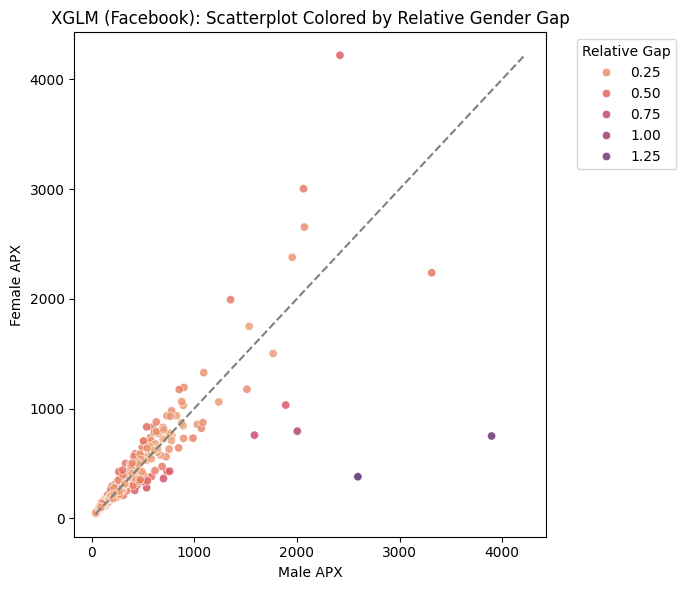

Top 10 Relative Gender Gaps — XGLM (Facebook):
gender           female         male  relative_gap
descriptor                                        
文人           378.419739  2593.747126      1.490715
警察           749.494403  3896.735550      1.354750
作家           793.777132  2003.437920      0.864904
记者           757.496962  1586.149219      0.707148
村民           361.301363   699.434249      0.637544
保姆           278.098929   535.320633      0.632445
司机          1031.802947  1890.859296      0.587859
美丽           428.401611   760.939347      0.559197
不育          4218.606751  2419.023468      0.542237
大学毕业生        427.155270   735.450303      0.530352


In [ ]:
df = pd.read_csv('result/2_facebook_xglm-4.5B_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean().reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['relative_gap'] = 2 * (desc_stats['female'] - desc_stats['male']).abs() / (desc_stats['female'] + desc_stats['male'])

plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='relative_gap', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("XGLM (Facebook): Scatterplot Colored by Relative Gender Gap")
plt.legend(title="Relative Gap", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Top 10 Relative Gender Gaps — XGLM (Facebook):")
print(desc_stats.sort_values('relative_gap', ascending=False).head(10)[['female', 'male', 'relative_gap']])


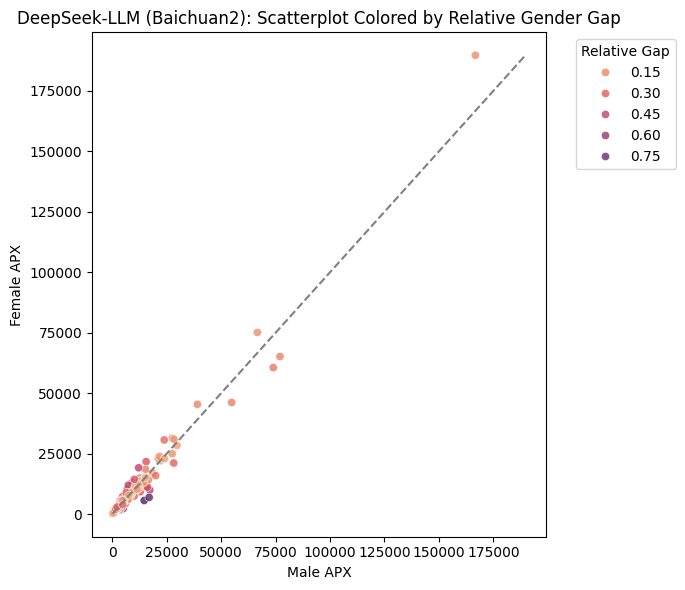

Top 10 Relative Gender Gaps — DeepSeek (Baichuan2):
gender           female          male  relative_gap
descriptor                                         
漂亮          5602.723429  14629.566302      0.892320
美丽          6892.014198  16915.742775      0.842056
俏丽          2252.277207   4964.358255      0.751619
娇媚          1733.397379   3373.874403      0.642408
家庭主妇         205.363678    383.550589      0.605137
贤淑          1700.033625   3087.330319      0.579566
丰满          9916.284419  17164.586535      0.535308
英俊          1516.345794    885.961957      0.524815
娇俏          1907.879393   3229.002210      0.514368
娴雅          2471.754377   4154.282923      0.507854


In [ ]:
df = pd.read_csv('result/2_deepseek-ai_deepseek-llm-7b-base_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean().reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['relative_gap'] = 2 * (desc_stats['female'] - desc_stats['male']).abs() / (desc_stats['female'] + desc_stats['male'])

plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='relative_gap', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("DeepSeek-LLM (Baichuan2): Scatterplot Colored by Relative Gender Gap")
plt.legend(title="Relative Gap", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Top 10 Relative Gender Gaps — DeepSeek (Baichuan2):")
print(desc_stats.sort_values('relative_gap', ascending=False).head(10)[['female', 'male', 'relative_gap']])


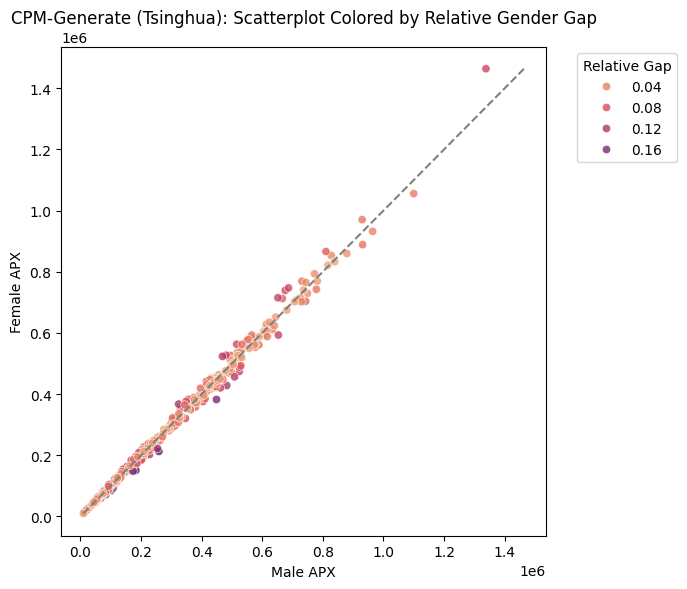

Top 10 Relative Gender Gaps — CPM-Generate (Tsinghua):
gender             female           male  relative_gap
descriptor                                            
纤细          212706.892361  259069.075865      0.196543
娇媚          150594.139085  183006.537301      0.194319
娇俏           84917.114213  101156.155228      0.174545
娇小          382362.086248  449020.644873      0.160356
纤弱          147945.445621  173700.835851      0.160147
温婉           71909.714162   84239.405366      0.157922
温顺           92241.252845  107435.407521      0.152188
美丽          222146.986314  254497.112723      0.135741
酷           367263.941216  324082.105593      0.124921
娇生惯养         59920.529169   67703.699271      0.121970


In [ ]:
df = pd.read_csv('result/2_TsinghuaAI_CPM-Generate_results_apx.csv', on_bad_lines='warn')
df['gender'] = df['gender'].replace({'m': 'male', 'f': 'female'})
df['apx_mean'] = df[['apx_1', 'apx_2', 'apx_3']].mean(axis=1)

desc_stats = (
    df.groupby(['descriptor', 'gender'])['apx_mean']
    .mean().reset_index()
    .pivot(index='descriptor', columns='gender', values='apx_mean')
    .dropna()
)

desc_stats['relative_gap'] = 2 * (desc_stats['female'] - desc_stats['male']).abs() / (desc_stats['female'] + desc_stats['male'])

plt.figure(figsize=(7, 6))
sns.scatterplot(data=desc_stats, x='male', y='female', hue='relative_gap', palette='flare', alpha=0.8, edgecolor='w')
min_val, max_val = desc_stats[['male', 'female']].min().min(), desc_stats[['male', 'female']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
plt.xlabel("Male APX")
plt.ylabel("Female APX")
plt.title("CPM-Generate (Tsinghua): Scatterplot Colored by Relative Gender Gap")
plt.legend(title="Relative Gap", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Top 10 Relative Gender Gaps — CPM-Generate (Tsinghua):")
print(desc_stats.sort_values('relative_gap', ascending=False).head(10)[['female', 'male', 'relative_gap']])
